In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from segregation.aspatial import Entropy
import os
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import truncnorm, norm, beta
import SALib
import multiprocessing as mp
import time
import itertools
from datetime import date
import matplotlib as mpl

import sys
sys.path.insert(0, "../compass")
from parameters import FLAGS

sys.path.insert(0, "../")
from datacrawler import DataCrawler

In [3]:
name = 'convergence-sobol'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")
names = {'homophily_std':'Optimal fraction std.',
    'max_move_fraction': 'Fraction moving',
    'num_considered':'# Considered empty spots',
    'scheduling': 'Scheduling'}

# General plot settings 

In [4]:
# print(mpl.rcParams.keys)
sns.set(style="whitegrid", font_scale=1.5)
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['grid.alpha'] = 1

# colors = itertools.cycle((',', '+', '.', 'o', '*'))
markers = ('o', 'v', 's', 'd', '<', '+')

# Function to save figures

In [5]:
# Create directory if it does not exist yet.
plot_path = f'../plots/{name}'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

def save_figure(plot_path, filename):
    today = date.today()
    _ = plt.savefig(f'{plot_path}/{filename}-{today.strftime("%d-%m-%Y")}.pdf')

In [6]:
def calculate_theil(data):
        """
        Calculate Theil's information index (own implementation).

        Args:
            data (DataFrame): DataFrame where every row corresponds to an
                organisational unit (e.g., school or neighbourhood). Columns
                should contain the absolute counts of groups.

        Todo:
            *Column names are hardcoded for now, this should change.
        """

        compositions = pd.DataFrame(data=data, columns=['comp_0','comp_1'])
        global_composition = compositions.sum(axis=0)
        global_composition_normalized = global_composition / global_composition.sum()
        pi_m = global_composition_normalized.values

        t_j = compositions.sum(axis=1)
        pi_jm = compositions.divide(t_j, axis=0)
        T = t_j.sum()
        r_jm = pi_jm / pi_m

        global_entropy = - np.sum(pi_m * np.log(pi_m))
        E = global_entropy
        log_r_jm = np.nan_to_num(np.log(r_jm))

        H = np.sum((t_j / (T * E)) * (pi_jm * log_r_jm).T)
        theil = H.sum()
        return theil

In [7]:
def extract_windows_vectorized(array, sub_window_size):
    max_time = len(array) - sub_window_size
    sub_windows = (
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    return array[sub_windows]


def convergence_calculations(filename):
    convergence = []
    sizes = [10, 20, 30, 40, 50]
    thresholds = [0.02, 0.01, 0.005, 0.001]
    
    # Load the .npz file
    data = np.load(path_to_frame + filename + '.npz', allow_pickle=True)
    
    # Calculate the utility metrics for every time step
    household_utility = data['households'][:,:,4]
    mean_u = household_utility.mean(axis=1)
    std_u = household_utility.std(axis=1)
    
    # Grab neighbourhood and school data
    neighbourhoods = data['neighbourhoods']
    schools = data['schools']
    last_res_step, _, _ = neighbourhoods.shape
    last_school_step, _, _ = schools.shape
    
     # Calculate residential and school segregation every timestep
    res_seg = np.array([calculate_theil(schools[step,:,:2]) \
                   for step in range(last_res_step)])
#     school_seg = np.array([calculate_theil(schools[step,:,:2]) \
#                       for step in range(last_school_step)])
    
    for size in sizes:
        
        # Calculate mean absolute deviations
        windows = extract_windows_vectorized(res_seg, sub_window_size=size)
        mad = np.abs((windows - np.repeat(windows.mean(axis=1)[
            :, np.newaxis], size, axis=1)))

        # Loop over sorted (descending) thresholds
        for threshold in thresholds:
            step = 0
            
            for index, row in enumerate(mad[step:]):

                # Check whether every MAD is within the threshold
                if np.all(row<threshold):
                    step += index
                    convergence.append([filename, 
                                        size, 
                                        threshold, 
                                        step+size-1, 
                                        0, 
                                        0, 
                                        res_seg[step+size-1]])
                    
                    break
    
    # Also append segregation level in last step
    convergence.append([filename, 
                        None, 
                        None, 
                        len(res_seg)-1, 
                        0, 
                        0, 
                        res_seg[-1]])
    
    return np.array(convergence)

In [8]:
# chunksize = 3
# start = time.time()
# with mp.Pool() as p:
#     all_data = list(tqdm(p.imap(
#         convergence_calculations, frame.filename,
#         chunksize=chunksize), total=frame.filename.shape[0]))
# end = time.time()
# print("Time elapsed:", end - start)

# convergence_data = pd.DataFrame(np.concatenate(all_data), columns=['filename', 'size', 'threshold', 
#                                           'convergence_step', 'mean_u', 'std_u', 'res_seg'])
# convergence_data = convergence_data.astype(
#     {'filename':'object', 'size':'float64', 'threshold':'float64', 'convergence_step':'float64',
#      'mean_u': 'float64', 'std_u': 'float64', 
#      'res_seg': 'float64'})

In [16]:
# Save or load the data depending on the calculations are already made
# convergence_data.to_pickle(f"{path_to_frame}convergence-data-{name}.pkl", protocol=4)
convergence_data = pd.read_pickle(f"{path_to_frame}convergence-data-{name}.pkl")
#convergence_data = pd.read_pickle(f"{path_to_frame}convergence-data-schools-{name}.pkl")

In [17]:
# Calculate differences in output when converged with that of the last step
differences = pd.DataFrame()
for filename in tqdm(convergence_data.filename.unique()):
    
    # Grab all the data associated with the filename
    temp_data = convergence_data[convergence_data.filename==filename]
    # Grab data from last step (999 if thousand steps)
    subtraction = temp_data[(temp_data.convergence_step==499)][['mean_u', 'std_u', 'res_seg']].iloc[0]
    abs_difference = (temp_data[['mean_u', 'std_u', 'res_seg']]-subtraction).abs()
    differences = pd.concat([differences, abs_difference])
convergence_data[['mean_u_diff', 'std_u_diff', 'res_seg_diff']] = differences
print(convergence_data.describe())

100%|██████████| 800/800 [00:05<00:00, 150.20it/s]

               size     threshold  convergence_step   mean_u    std_u  \
count  14338.000000  14338.000000      15138.000000  15138.0  15138.0   
mean      29.712652      0.009511         67.204320      0.0      0.0   
std       14.173213      0.007124        108.878519      0.0      0.0   
min       10.000000      0.001000          9.000000      0.0      0.0   
25%       20.000000      0.005000         24.000000      0.0      0.0   
50%       30.000000      0.010000         39.000000      0.0      0.0   
75%       40.000000      0.020000         53.000000      0.0      0.0   
max       50.000000      0.020000        499.000000      0.0      0.0   

            res_seg  mean_u_diff  std_u_diff  res_seg_diff  
count  15138.000000      15138.0     15138.0  1.513800e+04  
mean       0.604602          0.0         0.0  1.846454e-03  
std        0.438590          0.0         0.0  1.225765e-02  
min        0.000039          0.0         0.0  0.000000e+00  
25%        0.045134          0.0     

In [18]:
# Merge the data with all parameter values
merged = convergence_data.merge(frame, left_on='filename', right_on='filename')

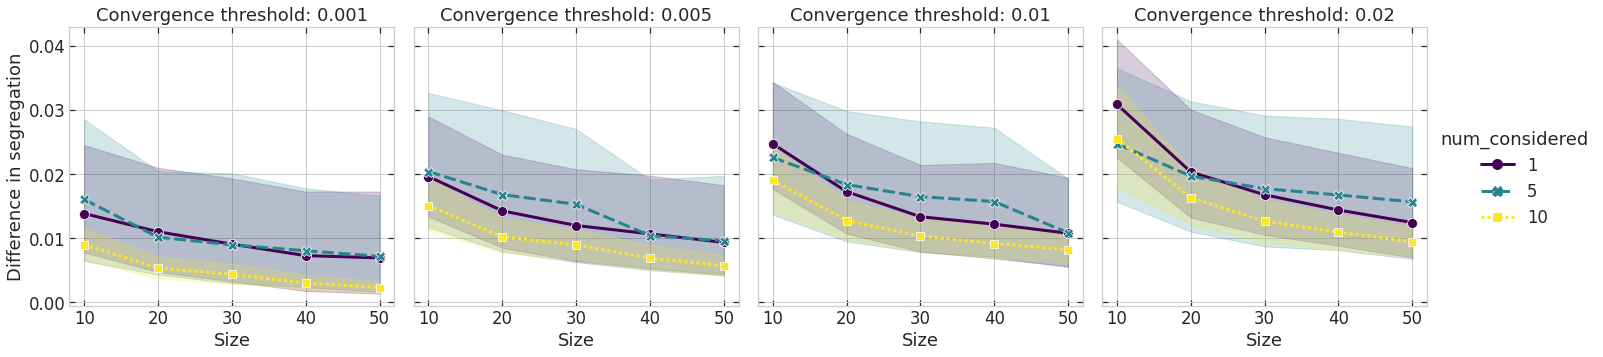

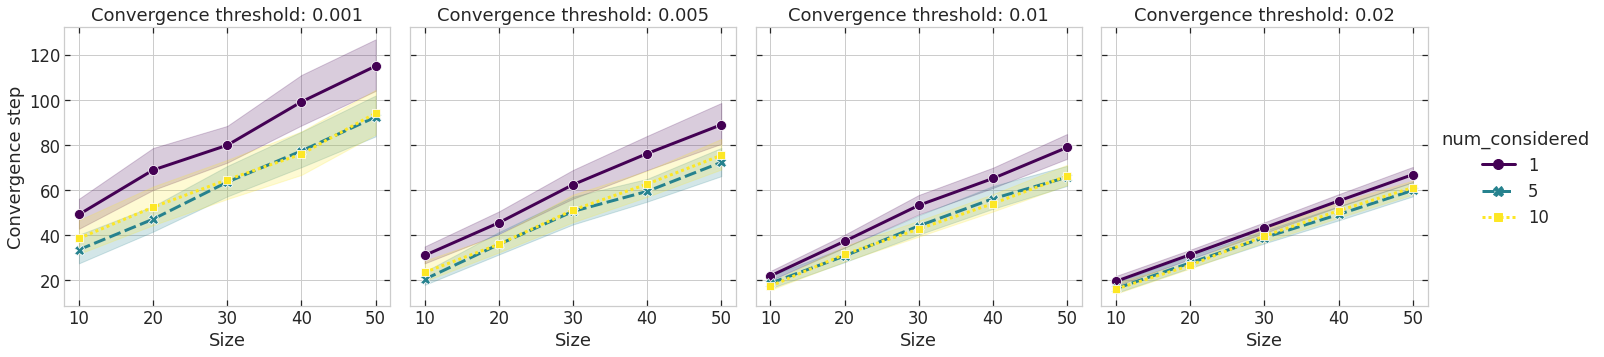

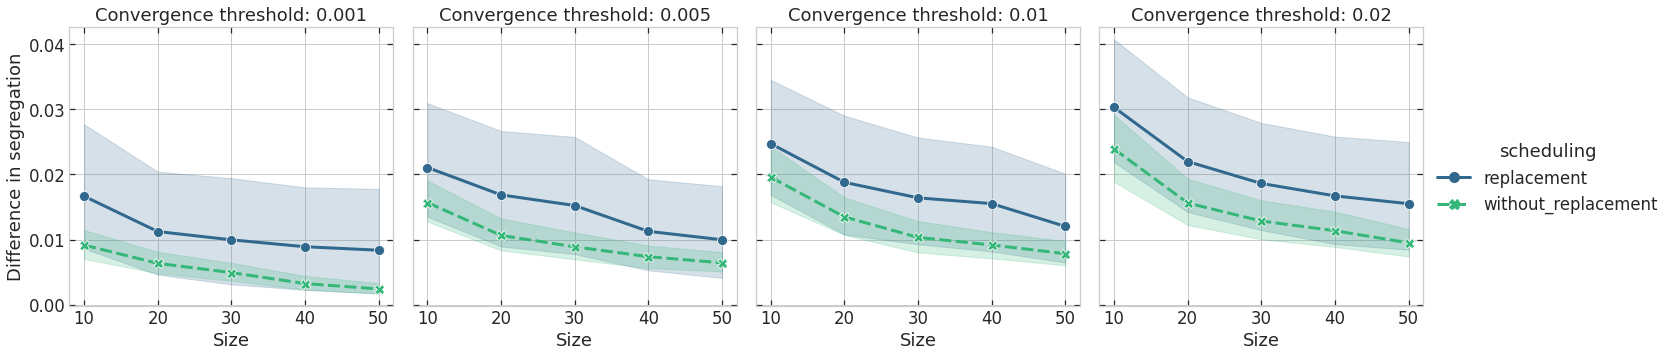

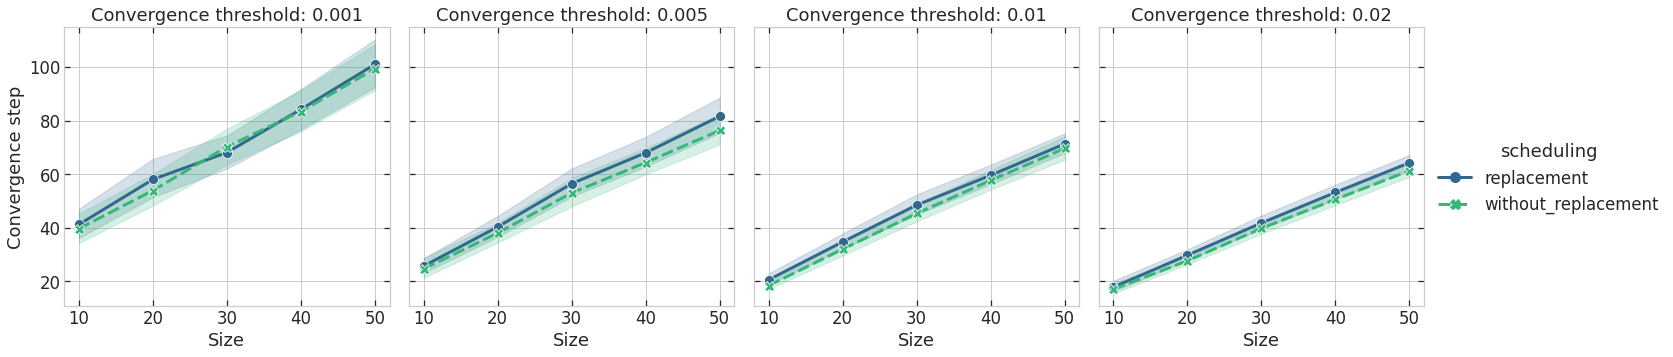

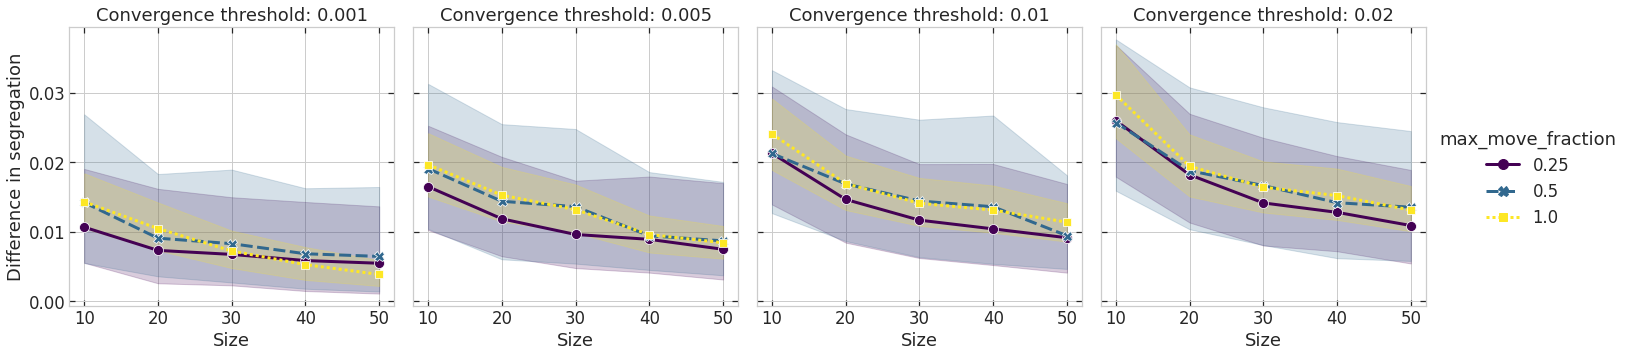

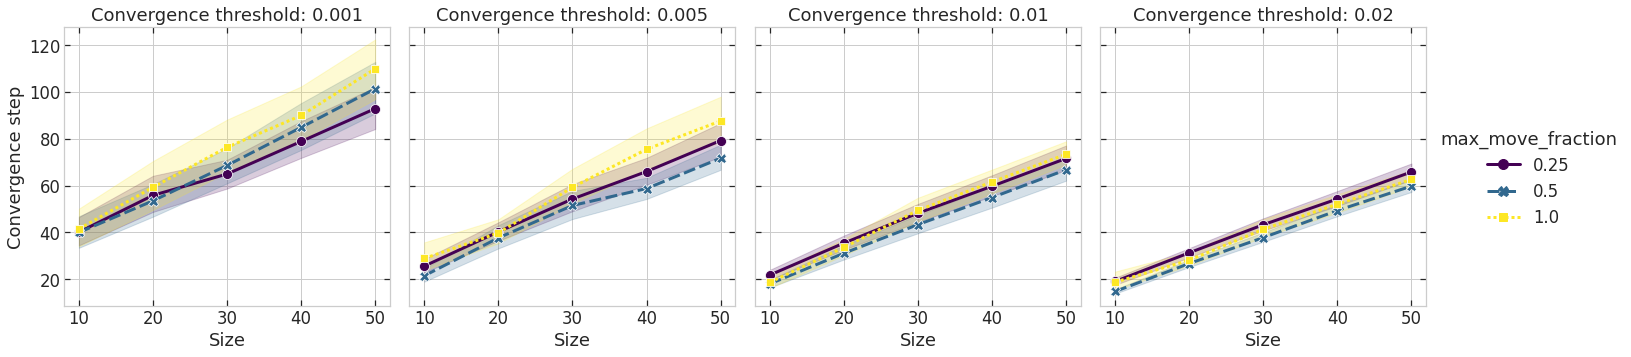

In [12]:
for par in ['num_considered', 'scheduling', 'max_move_fraction']:
    
    for y in ['res_seg_diff', 'convergence_step']:
        g = sns.relplot(data=merged, x="size", y=y, 
                col="threshold", kind="line", hue=par, 
                style=par, palette='viridis', markers=True)
        
        if y=='res_seg_diff':
            label = 'Difference in segregation'
        else:
            label = 'Convergence step'
        
        g.set_axis_labels("Size", label)
        g.set_titles("Convergence threshold: {col_name}")
        
        for ax in g.axes.flatten():
            sns.despine(ax=ax, top=False, right=False)
        
        save_figure(plot_path, filename='convergence-residential-'+label.lower()+'-'+par)

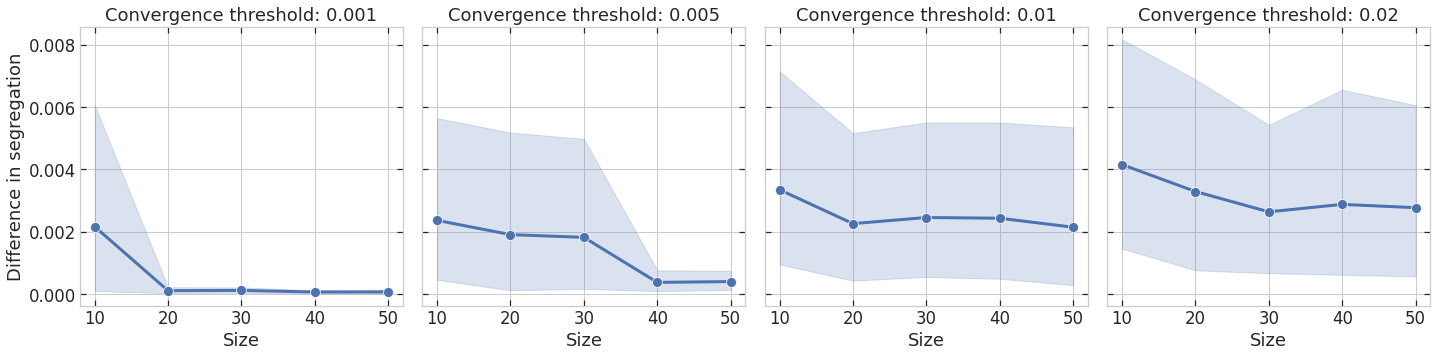

In [20]:
nominal_values = {'num_considered':10,
                    'max_move_fraction':0.25,
                    'scheduling':'without_replacement'}

filtered = frame.copy()
for var_name, value in nominal_values.items():
    filtered = filtered[filtered[var_name]==value]
filenames = [filename for filename in filtered.filename]
filtered = merged[merged.filename.isin(filenames)]

for y in ['res_seg_diff']:#, 'mean_u_diff', 'std_u_diff']: 
    g = sns.relplot(data=filtered, x="size", y=y, 
                    col="threshold", kind="line",
                   marker=markers[0])
    
    g.set_axis_labels("Size", 'Difference in segregation')
    g.set_titles("Convergence threshold: {col_name}")

    for ax in g.axes.flatten():
        sns.despine(ax=ax, top=False, right=False)
        ax.tick_params(bottom=True, top=True, 
                       left=True, right=True, direction='in')
    save_figure(plot_path, filename='convergence-residential-fixed'+label.lower()+'-'+par)

In [14]:
print('Stop here')
raise ValueError

Stop here


ValueError: 

In [ ]:
nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
fig.suptitle(f'Convergence metrics', fontsize=24)
filenames = filtered.filename.sample(n=25)

for filename in tqdm(filenames): #filtered.filename.unique()
    data = np.load(path_to_frame + filename + '.npz', allow_pickle=True)
    household_utility = data['households'][:,:,4]
    mean_u = household_utility.mean(axis=1)
    std_u = household_utility.std(axis=1)

    neighbourhoods = data['neighbourhoods']
    schools = data['schools']
    last_res_step, _, _ = neighbourhoods.shape
    last_school_step, _, _ = schools.shape

    # Calculate residential and school segregation every timestep
    res_seg = np.array([calculate_theil(neighbourhoods[step,:,:2]) \
               for step in range(last_res_step)])
    school_seg = np.array([calculate_theil(schools[step,:,:2]) \
                      for step in range(last_school_step)])

    for row in range(nrows):

        if row==0:
            y = mean_u
        elif row==1:
            y = std_u

        for col in range(ncols):
            if row==2:
                if col==0:
                    values = res_seg
                else:
                    values = school_seg

            elif col==0:
                values = y[:last_res_step+1]

            else:
                values = y[last_res_step+1:]
            
            sns.lineplot(x=range(len(values)), y=values, ax=axs[row,col])

for index, title in enumerate(['Mean utility', 
            'Standard deviation of utility', 'Segregation']):

    axs[index,0].set_title(title + ' (residential)', fontsize=20)
    axs[index,1].set_title(title + ' (school)', fontsize=20)
    
for ax in axs.flatten():
    sns.despine(ax=ax, top=False, right=False)
    
plt.tight_layout()
plot_path = f'../plots/convergence'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(f'{plot_path}/convergence.pdf')

# Archive

In [ ]:
#                 if True: #row==2 and col==0:
# #                     axs[row, col].set_xlim(200,600)
# #                     axs[row, col].set_ylim(0.6,1)
#                     colors = ['r', 'g', 'b']
#                     converged = {'10':False, '20':False, '30':False}
#                     for step in range(len(values)):
                        
#                         for index, size in enumerate([10, 20, 30]):

#                             if (not converged[str(size)] and step>size):

#                                 threshold = 0.01
#                                 window = values[step-size:step]
#                                 if np.all(np.abs(window-np.mean(window))<threshold):
#                                     rect = patches.Rectangle((step-size-1, 
#                                                              np.mean(window)-threshold), 
#                                                              size, 2*threshold, 
#                                                              linewidth=2, 
#                                                              edgecolor=colors[index], 
#                                                              facecolor='none')

#                                     # Add the patch to the Axes
#                                     axs[row,col].add_patch(rect)
#                                     converged[str(size)] = True







# def twin_lineplot(x, y, color, **kwargs):
#     ax = plt.twinx()
#     sns.lineplot(x=x, y=y, color=color, **kwargs, ax=ax)

# g = sns.FacetGrid(data=temp, col='threshold', sharey=True, legend_out=True)
# g.map(sns.lineplot, data=temp, x='size', y='res_seg_diff', hue=par, palette='viridis', legend=True)
# g.map(twin_lineplot, data=temp, x='size', y='convergence_step', hue=par, palette='viridis', legend=False)
# # g.fig.autofmt_xdate()
# plt.show()









            # Draw convergence boxes
#                 params = dict(np.ndenumerate(data['params']))[()]
#                 size = params['window_size']
#                 threshold = params['conv_threshold']
#                 window = values[-size:]
#                 rect = patches.Rectangle((len(values)-size-1, 
#                                          np.mean(window)-threshold), 
#                                          size, 2*threshold, 
#                                          linewidth=2, 
#                                          edgecolor='r', 
#                                          facecolor='none')

#                 # Add the patch to the Axes
#                 axs[row,col].add_patch(rect)